# 03. Data Processing - PySpark

## 03.1. Importação das bibliotecas

### 03.1.1. Importando as bibliotecas nativas do Python

In [1]:
import sys

### 03.1.2. Importando as bibliotecas de terceiros

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession, types as T
from pyspark.sql.functions import *
# from ydata_profiling import ProfileReport

### 03.1.3. Importando os módulos locais do projeto

In [3]:
sys.path.append('..')
import functions.fn_charts_pandas as fn_charts_pandas
import functions.fn_stats_pyspark as fn_stats_pyspark
import params.consts as consts

## 03.2. Visão geral dos dados

### 03.2.0. Iniciando a sessão Spark

In [4]:
spark = SparkSession.builder.appName('spark').getOrCreate()

### 03.2.1. Habilitando a exibição de todas as colunas

In [5]:
pd.set_option('display.max_columns', None)

### 03.2.2. Armazenando o dataset em uma variável

In [6]:
df = spark.read \
    .format('csv') \
    .option('header', 'true') \
    .option('inferSchema', 'true') \
    .option('sep', ',') \
    .load(consts.DATASET_RAW_COMPRESSED_PYSPARK)

### 03.2.3. Visualizando a quantidade de linhas e colunas do dataset

In [7]:
(df.count(), len(df.columns))

(2240, 31)

### 03.2.4. Exibindo o dataset

In [8]:
df.show(5)

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+-----------------+-------------------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|Dt_Customer_Month|Dt_Customer_Quarter|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+------

### 03.2.5. Visualizando os detalhes do dataset

In [9]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: date (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedCmp

### 03.2.6. Visualizando as estatísticas das colunas numéricas

In [10]:
fn_stats_pyspark.summary(df).show(truncate = False)

+-------+-------+----------+---------+--------------+--------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+-----------------+-------------------+
|summary|ID     |Year_Birth|Education|Marital_Status|Income  |Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|Dt_Customer_Month|Dt_Customer_Quarter|
+-------+-------+----------+---------+--------------+--------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+------

### 03.2.7. Visualizando as estatísticas da colunas categóricas

In [11]:
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, T.StringType)]

df.describe(categorical_columns).show()

+-------+---------+--------------+
|summary|Education|Marital_Status|
+-------+---------+--------------+
|  count|     2240|          2240|
|   mean|     NULL|          NULL|
| stddev|     NULL|          NULL|
|    min| 2n Cycle|        Absurd|
|    max|      PhD|          YOLO|
+-------+---------+--------------+



### 03.2.8. Verificando as colunas com valores nulos

In [12]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+-----------------+-------------------+
| ID|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|Dt_Customer_Month|Dt_Customer_Quarter|
+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+------------

## 03.3. Processamento dos dados

### 03.3.1. Corrigindo os tipos de dados das colunas

In [13]:
df = df.withColumn('Income', col('Income').cast('double'))

### 03.3.2. Tratando as colunas com valores nulos/vazios

In [14]:
df = df.na.drop(subset = ['Income'])

### 03.3.3. Criando colunas de tempo/idade

In [15]:
max_date = df.agg(max('Dt_Customer')).collect()[0][0]

df = df.withColumn('Days_Since_Enrolled', datediff(lit(max_date), df['Dt_Customer']))

df = df.withColumn('Years_Since_Enrolled', floor(df['Days_Since_Enrolled'] / 365))

df = df.withColumn('Age', lit(max_date.year) - df['Year_Birth'])

### 03.3.4. Mesclando colunas com muitas categorias

In [16]:
max_age = df.agg(max('Age')).collect()[0][0]

df = df.withColumn(
    'AgeGroup',
    when((col('Age') >= 18) & (col('Age') <= 30), '18-30')
    .when((col('Age') > 30) & (col('Age') <= 45), '31-45')
    .when((col('Age') > 45) & (col('Age') <= 60), '46-60')
    .when((col('Age') > 60) & (col('Age') <= max_age), '61+')
)

df = df.withColumn(
    'Marital_Status',
    when(col('Marital_Status').isin('Alone', 'Absurd', 'YOLO', 'Widow', 'Single', 'Divorced'), 'Single')
    .when(col('Marital_Status').isin('Together', 'Married'), 'Partner')
)

- Agrupamento da coluna: AgeGroup
+--------+----------+-----+
|AgeGroup|Percentage|Count|
+--------+----------+-----+
|18-30   |11.6      |257  |
|31-45   |43.5      |965  |
|46-60   |32.8      |727  |
|61+     |12.0      |267  |
+--------+----------+-----+



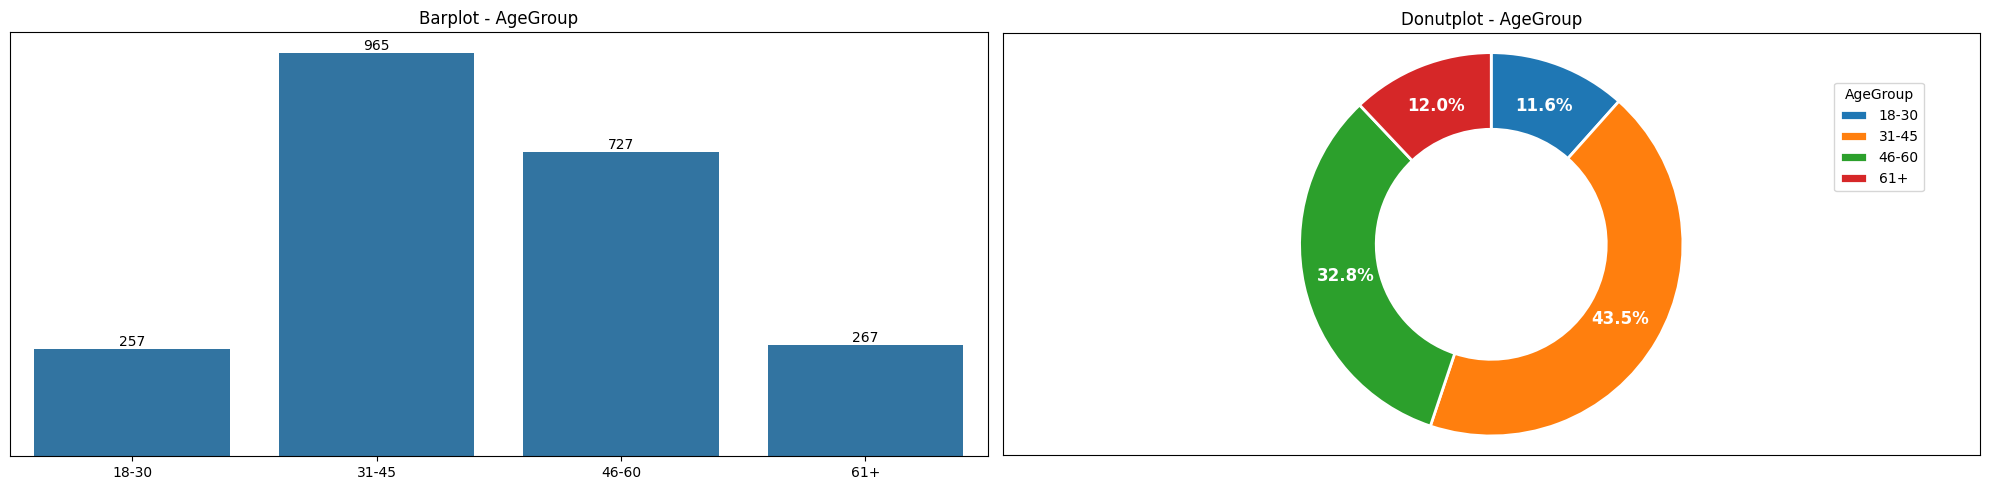

- Agrupamento da coluna: Marital_Status
+--------------+----------+-----+
|Marital_Status|Percentage|Count|
+--------------+----------+-----+
|Partner       |64.5      |1430 |
|Single        |35.5      |786  |
+--------------+----------+-----+



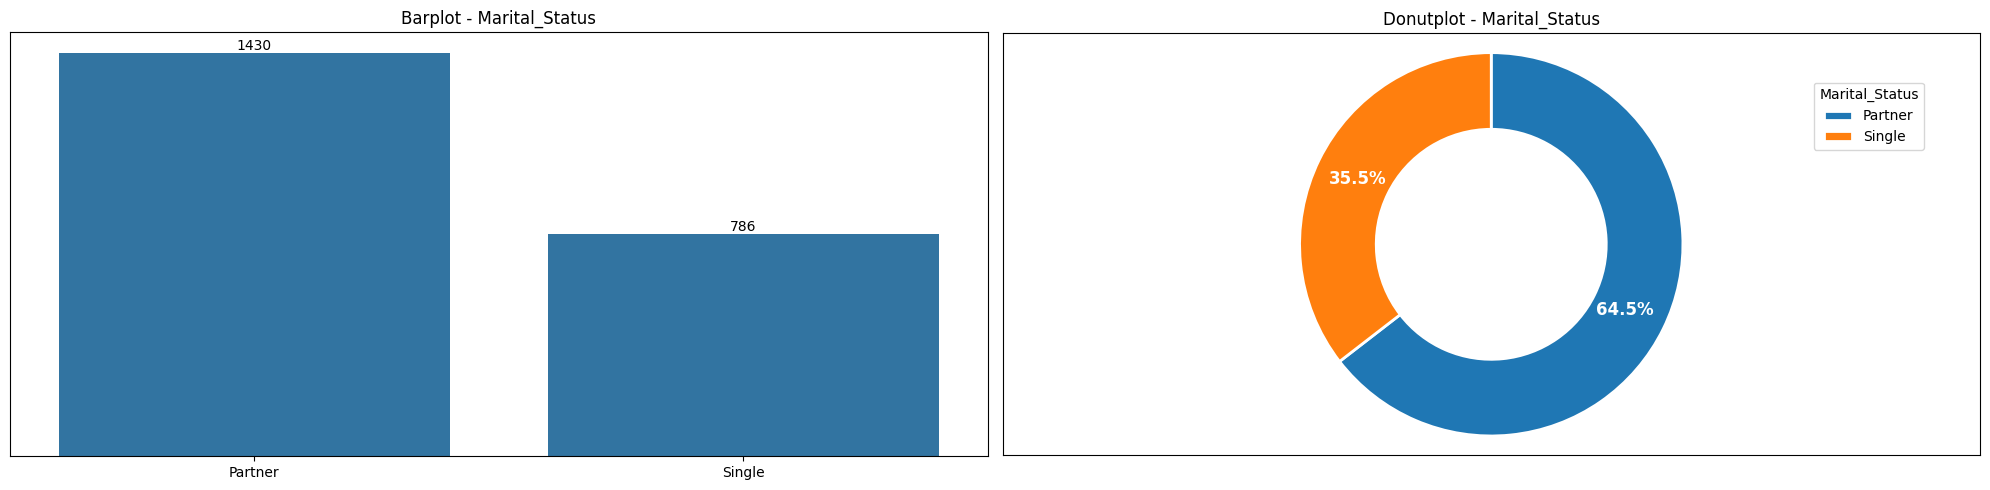

In [17]:
columns = ['AgeGroup', 'Marital_Status']

for i in columns:

    df_agg = fn_stats_pyspark.groupby_count(df, i)

    print(f'- Agrupamento da coluna: {i}')
    
    df_agg.show(truncate = False)

    fn_charts_pandas.barplot_donutplot(df_agg.toPandas(), i, 'Count')

    plt.savefig(f'../images/outputs/charts/pyspark/nb03_barplot_donutplot_{i.lower()}.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

    plt.show()

### 03.3.5. Unificando colunas semelhantes

In [18]:
df = (

    df.withColumn('Children', col('Kidhome') + col('Teenhome'))

      .withColumn('MntTotal',
          col('MntWines')
          + col('MntFruits')
          + col('MntMeatProducts')
          + col('MntFishProducts')
          + col('MntSweetProducts')
          + col('MntGoldProds')
      )

      .withColumn('AcceptedCmpTotal',
          col('AcceptedCmp1')
          + col('AcceptedCmp2')
          + col('AcceptedCmp3')
          + col('AcceptedCmp4')
          + col('AcceptedCmp5')
      )

      .withColumn('NumTotalPurchases',
          col('NumWebPurchases')
          + col('NumCatalogPurchases')
          + col('NumStorePurchases')
      )

)

- Agrupamento da coluna: Children
+--------+----------+-----+
|Children|Percentage|Count|
+--------+----------+-----+
|0       |28.6      |633  |
|1       |50.4      |1117 |
|2       |18.8      |416  |
|3       |2.3       |50   |
+--------+----------+-----+



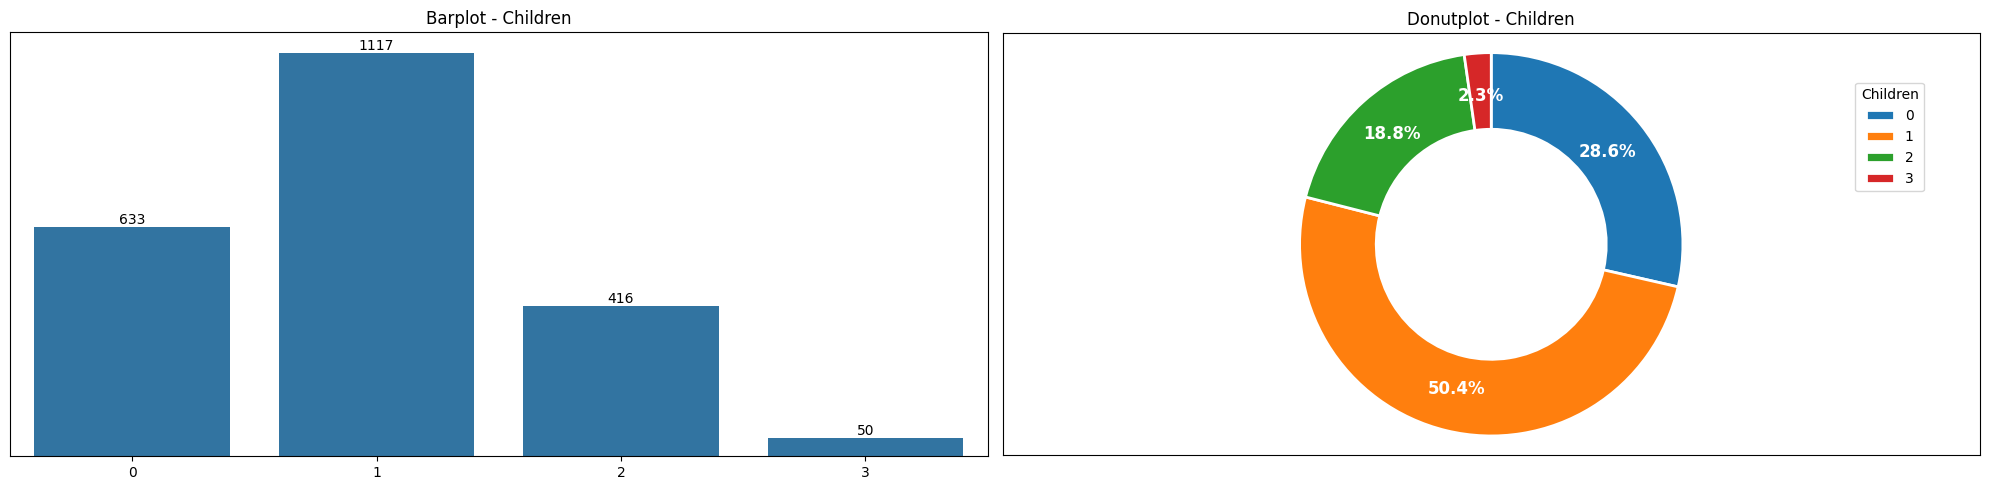

- Agrupamento da coluna: AcceptedCmpTotal
+----------------+----------+-----+
|AcceptedCmpTotal|Percentage|Count|
+----------------+----------+-----+
|0               |79.3      |1757 |
|1               |14.6      |323  |
|2               |3.7       |81   |
|3               |2.0       |44   |
|4               |0.5       |11   |
+----------------+----------+-----+



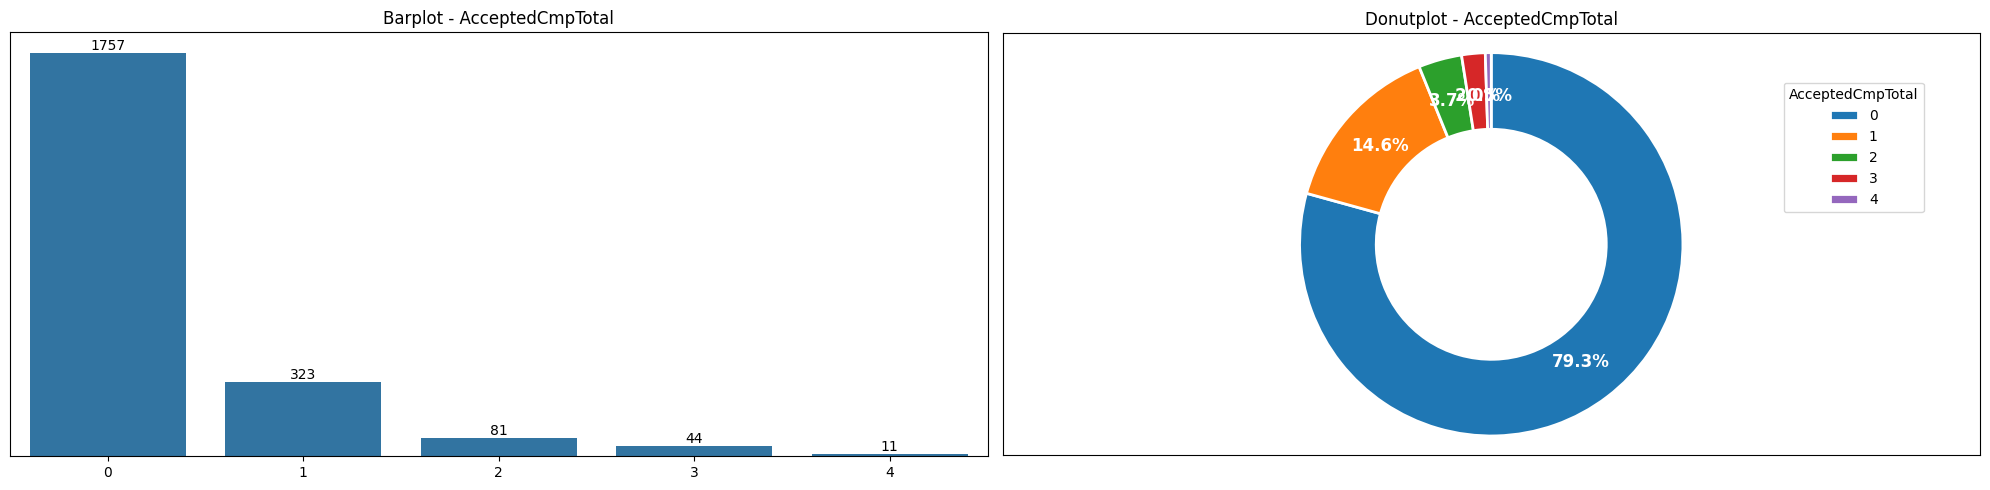

In [19]:
columns = ['Children', 'AcceptedCmpTotal']

for i in columns:

    df_agg = fn_stats_pyspark.groupby_count(df, i)

    print(f'- Agrupamento da coluna: {i}')
    
    df_agg.show(truncate = False)

    fn_charts_pandas.barplot_donutplot(df_agg.toPandas(), i, 'Count')

    plt.savefig(f'../images/outputs/charts/pyspark/nb03_barplot_donutplot_{i.lower()}.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

    plt.show()

### 03.3.6. Criando colunas derivadas de outras

In [20]:
df = (
    
    df.withColumn('HasChildren', when(col('Children') > 0, 1).otherwise(0))

      .withColumn('MntRegularProds', col('MntTotal') - col('MntGoldProds'))

      .withColumn('HasAcceptedCmp', when(col('AcceptedCmpTotal') > 0, 1).otherwise(0))
      
)

### 03.3.7. Tratando as colunas com outliers

In [21]:
columns_outliers = ['Age', 'Income', 'MntTotal'] 

- Gráfico: Diagrama de Caixa.


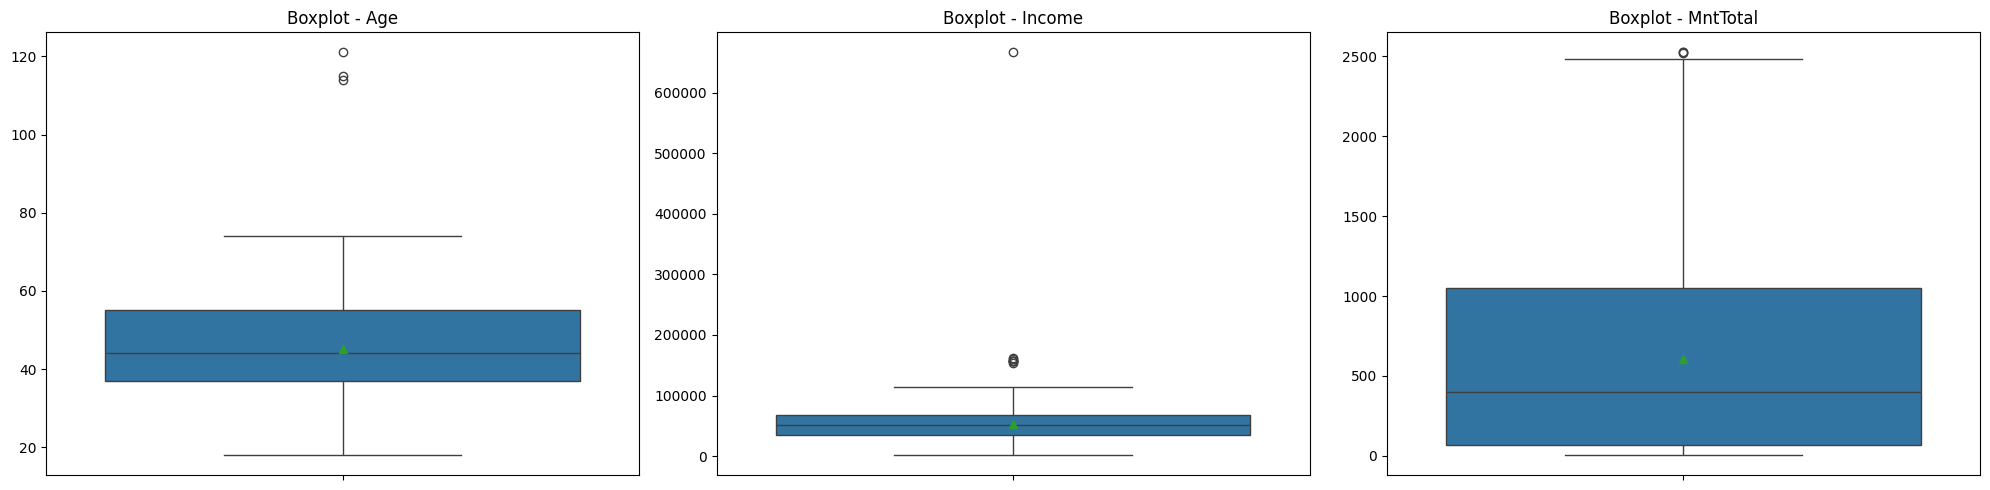

In [22]:
print('- Gráfico: Diagrama de Caixa.')

fn_charts_pandas.boxplot(df.toPandas(), columns_outliers)

plt.savefig(f'../images/outputs/charts/pyspark/nb03_boxplot_outliers_v1.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

In [23]:
for i in columns_outliers[:2]:

    print(f'- Outliers da coluna: {i}')
    
    fn_stats_pyspark.inspect_outliers(df, i).show()

- Outliers da coluna: Age
+-----+----------+---------+--------------+-------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+-----------------+-------------------+-------------------+--------------------+---+--------+--------+--------+----------------+-----------------+-----------+---------------+--------------+
|   ID|Year_Birth|Education|Marital_Status| Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enro

In [24]:
for i in columns_outliers[:2]:
    
    df = df.subtract(fn_stats_pyspark.inspect_outliers(df, i))

- Gráfico: Diagrama de Caixa.


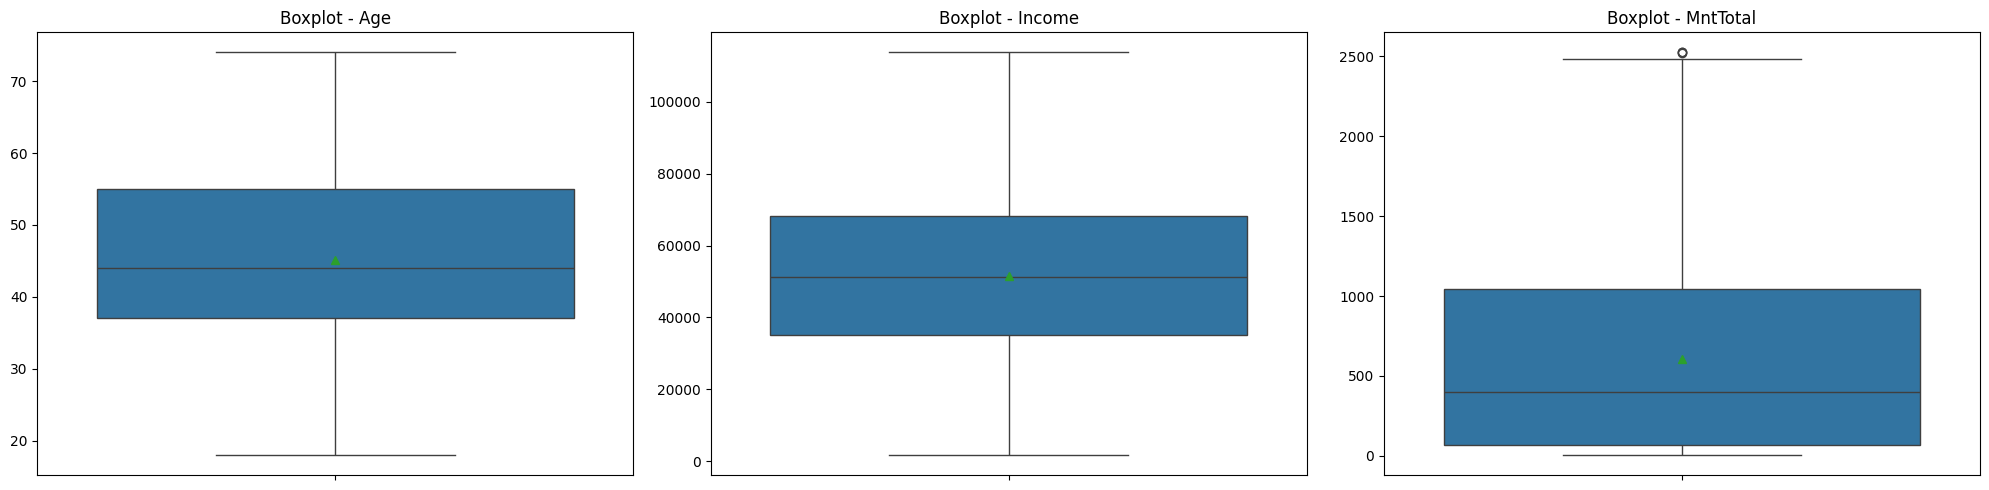

In [25]:
print('- Gráfico: Diagrama de Caixa.')

fn_charts_pandas.boxplot(df.toPandas(), columns_outliers)

plt.savefig(f'../images/outputs/charts/pyspark/nb03_boxplot_outliers_v2.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 03.3.8. Excluindo as colunas que contém valores únicos

In [26]:
df = df.drop('ID')

### 03.3.9. Excluindo as colunas que contém valores constantes

In [27]:
df = df.drop('Z_CostContact', 'Z_Revenue')

### 03.3.10. Excluindo as colunas auxiliares

In [28]:
df = df.drop(
    'Dt_Customer', 
    'Year_Birth', 
    'Kidhome',
    'Teenhome',
    'MntWines', 
    'MntFruits', 
    'MntMeatProducts', 
    'MntFishProducts', 
    'MntSweetProducts',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5', 
    'NumWebPurchases', 
    'NumCatalogPurchases', 
    'NumStorePurchases'
)

### 03.3.11. Ordenando as colunas

In [29]:
df = df.select(
    'Education', 
    'Marital_Status', 
    'Children',
    'HasChildren',
    'Age',
    'AgeGroup',
    'Income',
    'Recency',
    'Complain',
    'Dt_Customer_Month',
    'Dt_Customer_Quarter',
    'Days_Since_Enrolled',
    'Years_Since_Enrolled',
    'NumDealsPurchases',
    'NumWebVisitsMonth',
    'NumTotalPurchases',
    'MntRegularProds',
    'MntGoldProds',
    'MntTotal',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
    'Response',
)

## 03.4. Exportação dos dados

### 03.4.1. Salvando o dataset clean em parquet e compactado em snappy

In [30]:
df.write \
    .format('parquet') \
    .mode('overwrite') \
    .option('compression', 'snappy') \
    .save(consts.DATASET_CLEAN_PYSPARK)

### 03.4.2. Gerando um novo relatório Profile Report

In [31]:
# report_eda = ProfileReport(df)

# report_eda.to_file(consts.EDA_1)